## Basic parallax survey simulation

The code below shows the example of a simulated parallax survey, where the only data collected are the parallaxes and apparent magnitudes for sample of stars that have a uniform space density distribution. The distribution of distances is thus
\begin{equation}
    r \sim \begin{cases}
        r^2 & r_\mathrm{L} \leq r \leq r_\mathrm{H} \\
        0 & \text{otherwise}
    \end{cases}\,,
\end{equation}

where $r_\mathrm{L}$ and $r_\mathrm{H}$ are the lower and upper limits on the distance. The implied distribution of true parallaxes $\varpi_\mathrm{true}$ is

\begin{equation}
    \varpi_\mathrm{true} \sim 
    \begin{cases}
    \varpi_\mathrm{true}^{-4} & \varpi_\mathrm{L}\leq 
    \varpi_\mathrm{true}\leq \varpi_\mathrm{H}\\
    0 & \text{otherwise}
    \end{cases}\,,
\end{equation}

where $\varpi_\mathrm{L}=1000/r_\mathrm{H}$ and $\varpi_\mathrm{H}=1000/r_\mathrm{L}$ are the lower and upper limits on the true parallax (where throughout this notebook units of pc are used for distance and milli-arcsecond, mas, for parallax)\. The observed parallaxes $\varpi$ are distributed around the true values according to a normal distribution with standard deviation $\sigma_\varpi$:

\begin{equation}
    \varpi \sim {\cal N}(\varpi_\mathrm{true}, \sigma_\varpi)\,.
\end{equation}

The stars are all assumed to belong to the same class with an absolute magnitudes distribution

\begin{equation}
    M_\mathrm{true} \sim {\cal N}(\mu_M, \sigma_M)\,.
\end{equation}

The true and observed apparent magnitudes ($m_\mathrm{true}$ and $m$) are

\begin{equation}
    m_\mathrm{true} =  M_\mathrm{true} + 5\log_{10} r - 5 = M_\mathrm{true} - 5\log_{10} \varpi_\mathrm{true} + 10 \quad\text{and}\quad 
    m \sim {\cal N}(m_\mathrm{true},\sigma_m)\,.
\end{equation}

In addition the survey is magnitude limited, meaning that no apparent magnitudes above $m_\mathrm{lim}$ appear in the observed sample.

The code below makes use of the simulation tools to generate a parallax survey, which is specified by: the number of stars $N_\mathrm{stars}$, distributed with uniform density between distance limits of $r_\mathrm{L}$ and $r_\mathrm{H}$ and an absolute magnitude distribution specified by $\mu_M$ and $\sigma_M$, where the survey is limited to $m\leq m_\mathrm{lim}$. The number of observed stars, $N_\mathrm{survey}$, may thus be less than $N_\mathrm{stars}$. The plot panels show the resulting distribution of the true and observed parallaxes (top left), the true and observed apparent magnitudes (top right), the true absolute magnitudes and the distibrution of the absolute magnitudes for stars with "good" parallaxes (bottom left). In all cases "model" refers to the underlying distribution that generates the simulated true and observed quantities. The bottom right panel shows the difference between the true absolute magnitude and the one estimated from $m$ and $\varpi$ as $\widetilde{M} = m+5\log_{10}\varpi-10$, as a function of the relative uncertainty of the observed parallax.

The distribution of the true apparent magnitudes $p(m_\mathrm{true})$ can de derived analytically, as shown below.

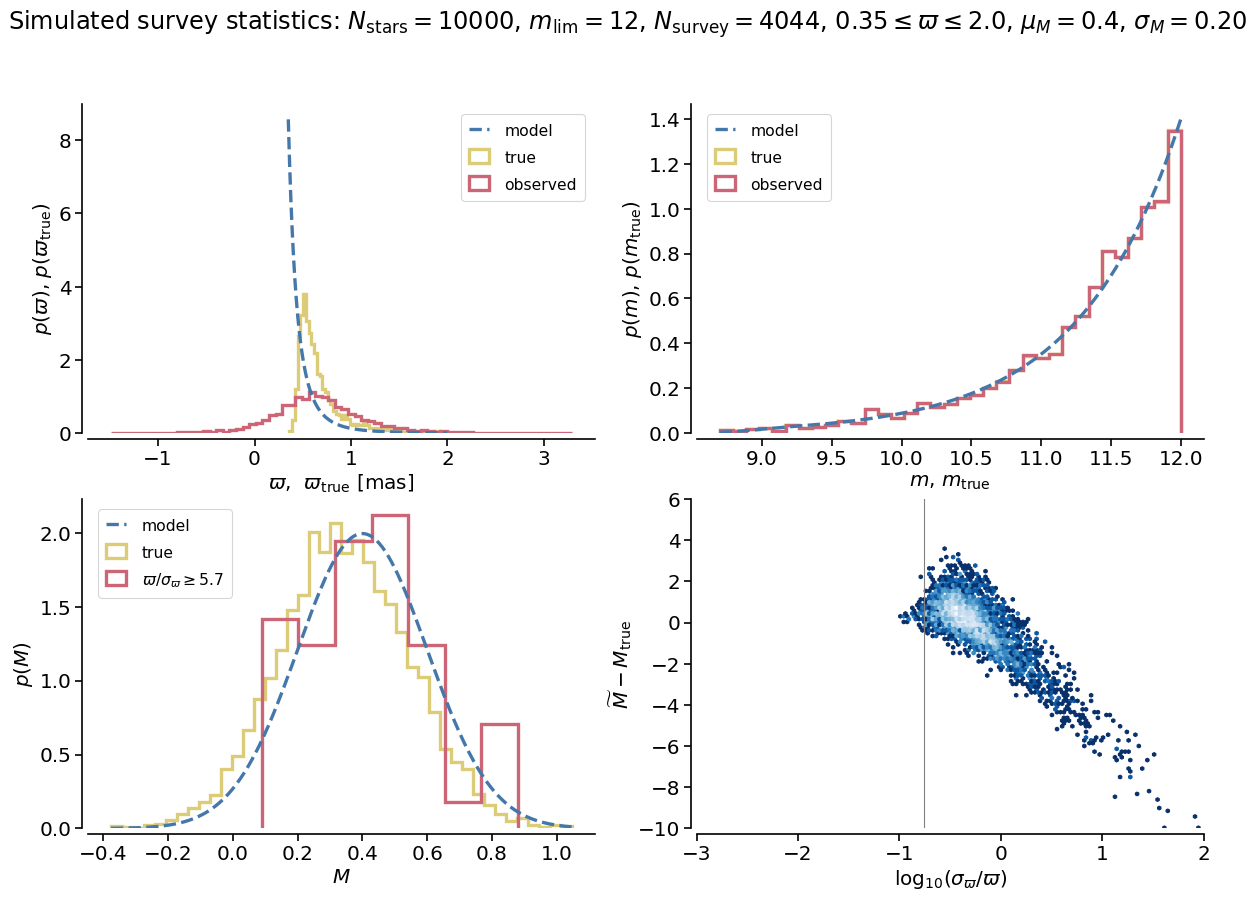

In [10]:
import numpy as np
import matplotlib.pylab as plt

from parallaxsurveys import UniformDistributionSingleLuminosityHip as udslH
from parallaxsurveys import UniformDistributionSingleLuminosityTGAS as udslT
from parallaxsurveys import showSurveyStatistics

distMin = 500.0
distMax = 1000.0/0.35
nStars = 10000
meanAbsMagTrue = 0.4
sigmaAbsMagTrue =  0.2
surveyseed = None
mlim = 12

# Hipparcos
#survey = udslH(nStars, distMin, distMax, meanAbsMagTrue, sigmaAbsMagTrue, surveyLimit=mlim)

# TGAS
survey = udslT(nStars, distMin, distMax, meanAbsMagTrue, sigmaAbsMagTrue, surveyLimit=mlim)

# Fix random seed
#survey.setRandomNumberSeed(53949896)

survey.generateObservations()
showSurveyStatistics(survey, usekde=False)

### Expected distribution of $m_\mathrm{true}$

We will now derive the expected distribution $p(m_\mathrm{true})$ of the true apparent magnitudes, first for the case of a complete survey ($m_\mathrm{lim}=\infty$). The apparent magnitude distribution derives from the distance distribution of the stars combined with the distribution of the stars over true absolute magnitude. So we first write down the full probability density for $r$:

\begin{equation}
    p(r) = \frac{3r^2}{A}\,, \quad\text{with}\quad A=r_\mathrm{H}^3 - r_\mathrm{L}^3\,,
\end{equation}

or in terms of $\varpi_\mathrm{true}$

\begin{equation}
    p(\varpi_\mathrm{true}) = \frac{3\varpi_\mathrm{true}^{-4}} {A'}\,, \quad\text{with}\quad
    A'=\varpi_\mathrm{L}^{-3} - \varpi_\mathrm{H}^{-3}\,.
\end{equation}

The apparent magnitude is $m_\mathrm{true} = M_\mathrm{true}+y$, where the variable $y=5\log_{10} r-5$ is the distance modulus, with $y_\mathrm{L} = 5\log_{10} r_\mathrm{L}-5 \leq y \leq 5\log_{10} r_\mathrm{H}-5 = y_\mathrm{H}$. The distribution of $y$ can be derived as:

\begin{equation}
    p(y) = p\left(r=10^{0.2(y+5)}\right) \times \left|\frac{dr}{dy}\right|
    = \frac{3\times10^{0.4*(y+5)}}{A}\left(0.2\ln 10 \times 10^{0.2(y+5)}\right)
    = \frac{0.6\ln 10}{A} \times 10^{0.6(y+5)}\,.
\end{equation}

For the distribution of $m_\mathrm{true}$ for a fixed value of $M_\mathrm{true}$ we can then write (making use of $y=m_\mathrm{true}-M_\mathrm{true}$):

\begin{equation}
    p(m_\mathrm{true}\mid M_\mathrm{true}) = \frac{0.6\ln 10}{A} \times 10^{0.6(m_\mathrm{true}-M_\mathrm{true}+5)}\,,
\end{equation}

This is of course the well known "star count law" for stars uniformly distributed around the observer.

In the simulation above the value of $M_\mathrm{true}$ is not fixed but has a normal distribution around $\mu_M$. In fact at fixed distance modulus $y$, $m_\mathrm{true}$ is distributed as ${\cal N}(y+\mu_M, \sigma_M)$, which implies that the distribution p($m_\mathrm{true})$ is given by the convolution of $p(y)$ and $p(M_\mathrm{true})$:

\begin{equation}
    p(m_\mathrm{true}) = \int_{y_\mathrm{L}}^{y_\mathrm{H}} p_y(y)p_{M_\mathrm{true}}(m_\mathrm{true}-y)\,dy =
    \int_{y_\mathrm{L}}^{y_\mathrm{H}} \frac{0.6\ln 10}{A} \times 10^{0.6(y+5)} \times
    \frac{1}{\sigma_M\sqrt{2\pi}} \exp\left(-\frac{1}{2}\left(\frac{m_\mathrm{true}-y-\mu_M}
    {\sigma_M}\right)^2\right)\,dy\,,
\end{equation}

which can be written as:

\begin{equation}
    p(m_\mathrm{true}) = \frac{0.6\ln 10}{A\sigma_M\sqrt{2\pi}} \int_{y_\mathrm{L}}^{y_\mathrm{H}}
    \exp\left(0.6\ln 10(y+5)\right) \exp\left(-\frac{1}{2}\left(\frac{m_\mathrm{true}-y-\mu_M}
    {\sigma_M}\right)^2\right)\,dy\,.
\end{equation}

By introducing the quantities $B=m_\mathrm{true}-\mu_M$ and $C=0.6\ln10$, the terms in the exponent of $e$ in the integral can be written as:

\begin{equation}
    -\frac{1}{2}\left(\frac{y-B}{\sigma_M}\right)^2 + C(y+5)\,.
\end{equation}

This expression can (after some basic manipulation) be written as:

\begin{equation}
    -\frac{1}{2}\left(\frac{y-(B+C\sigma_M^2)}{\sigma_M}\right)^2 + BC + \frac{1}{2}C^2\sigma_M^2 + 5C\,,
\end{equation}

which separates out the constant terms in the integral from those involving $y$:

\begin{equation}
    p(m_\mathrm{true}) = \frac{C}{A} \exp\left(C(B+C\sigma_M^2/2+5)\right) 
    \int_{y_\mathrm{L}}^{y_\mathrm{H}} \frac{1}{\sigma_M\sqrt{2\pi}} 
    \exp\left(-\frac{1}{2}\left(\frac{y-(B+C\sigma_M^2)}{\sigma_M}\right)^2\right)\,dy
\end{equation}

The integral can be worked out in terms of the error function:
\begin{equation}
    \mathrm{erf}(z) = \int_0^z \frac{2}{\sqrt{\pi}} e^{-t^2}\,dt\,.
\end{equation}

This leads to:

\begin{equation}
    p(m_\mathrm{true}) = \frac{C}{A} \exp\left(C(B+C\sigma_M^2/2+5)\right) \frac{1}{2}
    \left(\mathrm{erf}\left(\frac{y_\mathrm{H}-(B+C\sigma_M^2)}{\sigma_M\sqrt{2}}\right) -
    \mathrm{erf}\left(\frac{y_\mathrm{L}-(B+C\sigma_M^2)}{\sigma_M\sqrt{2}}\right) \right)
\end{equation}

For a finite value of $m_\mathrm{lim}$ the functional form for $p(m_\mathrm{true})$ will be cut-off at $m_\mathrm{lim}$. The probability distribution then has to be renormalized by numerical integration. This truncated form is only an approximation as in reality (and in the survey simulation above) the truncation is done on the _observed_ value $m$, which includes an error and this introduces a certain fuziness in the cut-off of $m_\mathrm{true}$. This 'fuziness' will depend on the details of the survey.

## Expected distributions of $r$ and $M_\mathrm{true}$ in the presence of a survey limit

In the simulated survey above the joint distribution of $r$ and $M_\mathrm{true}$ is given by

\begin{equation}
    p(r,M_\mathrm{true}) = \frac{3r^2}{A}{\cal N}(M_\mathrm{true}\mid \mu_M,\sigma_M)\,,
\end{equation}

where $A=r^3_\mathrm{H}-r^3_\mathrm{L}$, and the distribution is normalized in the absence of a survey limit. If there is a survey limit $m_\mathrm{lim}$ the following holds

\begin{equation}
    M_\mathrm{true}+5\log_{10} r-5\leq m_\mathrm{lim}\,,
\end{equation}

where again the details of how the survey cut-off is realized in practice are ignored (see above). This relation allows one to obtain the marginal distributions for $r$ and $M_\mathrm{true}$:

\begin{equation}
    p(r) \propto \int_{-\infty}^{m_\mathrm{lim}-5\log_{10} r+5} p(r,M_\mathrm{true})\,dM_\mathrm{true} =
    \frac{3r^2}{A}\Phi\left(\frac{m_\mathrm{lim}-(\mu_M+5\log_{10} r-5)}{\sigma_M}\right)\,,
\end{equation}

\begin{equation}
    p(M_\mathrm{true}) \propto \int_{r_\mathrm{L}}^{r_\mathrm{lim}} p(r,M_\mathrm{true})\,dr = {\cal N}(M_\mathrm{true}\mid \mu_M,\sigma_M)\times
    \frac{r^3_\mathrm{lim}-r^3_\mathrm{L}}{A}\,,
\end{equation}

where $r_\mathrm{lim} = \mathrm{min}(r_\mathrm{H}, 10^{0.2(m_\mathrm{lim}-M_\mathrm{true}+5)})$
The marginal distribution can be normalized numerically. The function $\Phi(t)$ is the cumulative standard normal distribution:

\begin{equation}
    \Phi(t) = \int_{-\infty}^t \frac{1}{\sqrt{2\pi}} e^{-z^2/2}\,dz\,.
\end{equation}

The code block below shows the distributions of $r$ and $M_\mathrm{true}$ for several choices of survey parameters. Note how the mean of $M_\mathrm{true}$ shifts to values smaller than $\mu_M$ as $\sigma_m$ increases. This is due to increasingly favouring the brighter stars in the population when applying a mangnitude cut-off. The bottom panels show the value of $\langle M_\mathrm{true}\rangle-\mu_M$ as a function of $\sigma_M$ and $m_\mathrm{lim}$. The latter two panels in fact show a variant of the 'Malmquist bias' which occurs for magnitude limited surveys. In this case because there is an upper limit on $r$ the bias also depends on $m_\mathrm{lim}$. If there is no limit on $r$ the dependence of the bias on $m_\mathrm{lim}$ is very weak. I the case $r_\mathrm{L}=0$ and $r_\mathrm{H}=+\infty$ there is strictly no dependence of the bias on $m_\mathrm{lim}$ and then the bias (for a uniform space density of stars, as assumed throughout this notebook) is given by $-1.382\sigma_M^2$.

These results illustrate why simply selecting the stars with good parallaxes to calibrate their mean absolute magnitude can lead to biased results. The magnitude limit leads to the selection of the bright end of the population and this is made worse by selection on low values of the relative parallax error. The Bayesian inference approach explained in the [notebook on luminosity inference from magnitude limited parallax surveys](Luminosity_Inference_DistPrior.ipynb) can overcome these issues.

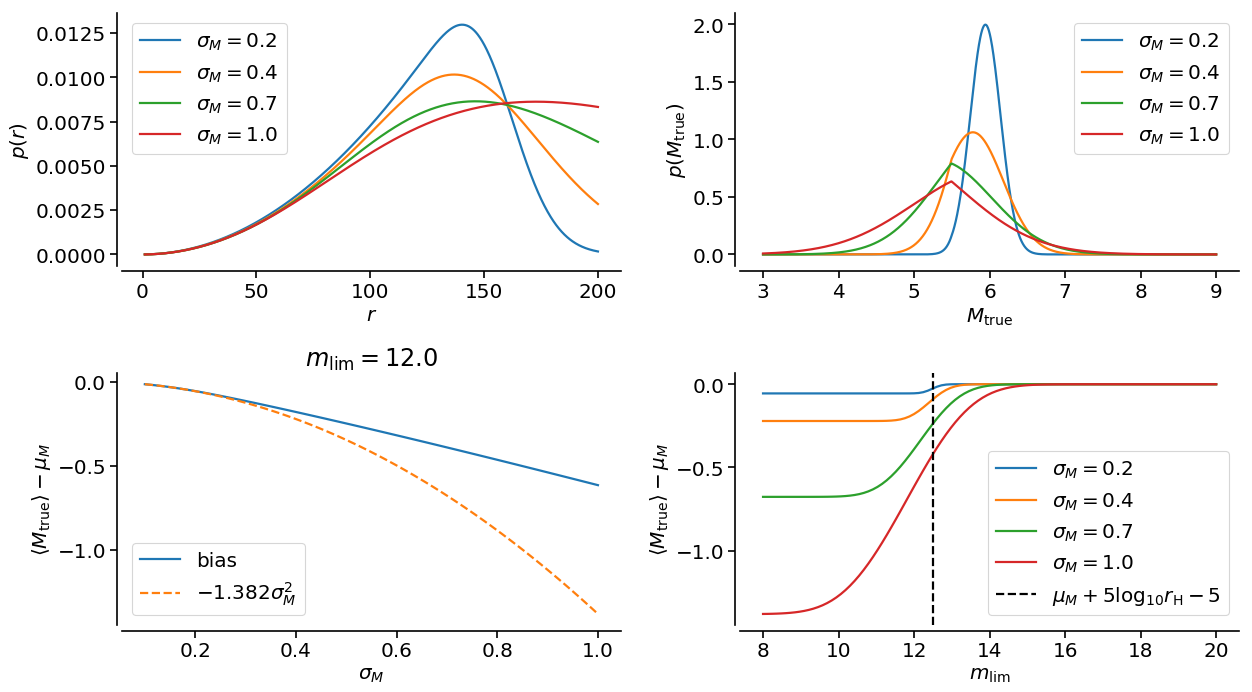

In [11]:
from scipy.stats import norm
from scipy.integrate import simps
from plotstyles import useagab, apply_tufte
from parallaxsurveys import marginal_pdf_distance, marginal_pdf_absMag

rmin = 1.0
rmax = 200.0
mu = 6.0
sigma = np.array([0.2, 0.4, 0.7, 1])
mlim = 12.0

r = np.linspace(rmin,rmax,1000)
M = np.linspace(mu-3*sigma.max(), mu+3*sigma.max(), 1000)

useagab(usetex=False, fontfam='sans', sroncolours=False)
fig, ((axA, axB), (axC, axD)) = plt.subplots(2, 2, figsize=(16,9))

apply_tufte(axA)
for s in sigma:
    axA.plot(r, marginal_pdf_distance(r,rmin,rmax,mu,s,mlim), label=r'$\sigma_M={0:.1f}$'.format(s))
axA.set_xlabel('$r$')
axA.set_ylabel('$p(r)$')
axA.legend()

apply_tufte(axB)
for s in sigma:
    axB.plot(M, marginal_pdf_absMag(M,rmin,rmax,mu,s,mlim), label=r'$\sigma_M={0:.1f}$'.format(s))
axB.set_xlabel('$M_\mathrm{true}$')
axB.set_ylabel('$p(M_\mathrm{true})$')
axB.legend()

bias = []
M=np.linspace(mu-5, mu+5, 1000)
ss = np.linspace(0.1, 1, 100)
for s in ss:
    bias.append(simps(M*marginal_pdf_absMag(M,rmin,rmax,mu,s,mlim), M)-mu)
apply_tufte(axC)
axC.plot(ss, bias, label='bias')
axC.plot(ss,-1.382*ss*ss,'--', label='$-1.382\sigma_M^2$')
axC.set_xlabel(r'$\sigma_M$')
axC.set_ylabel(r'$\langle M_\mathrm{true}\rangle-\mu_M$')
axC.set_title(r'$m_\mathrm{{lim}}={0:.1f}$'.format(mlim))
axC.legend()

mm = np.linspace(8, 20, 100)
apply_tufte(axD)
for s in sigma:
    bias = []
    for m in mm:
        bias.append(simps(M*marginal_pdf_absMag(M,rmin,rmax,mu,s,m), M)-mu)
    axD.plot(mm, bias, label=r'$\sigma_M={0:.1f}$'.format(s))
axD.set_xlabel(r'$m_\mathrm{lim}$')
axD.set_ylabel(r'$\langle M_\mathrm{true}\rangle-\mu_M$')
axD.axvline(x=mu+5*np.log10(rmax)-5, color='k', ls='--', label='$\mu_M+5\log_{10} r_\mathrm{H}-5$')
axD.legend()

plt.tight_layout()
plt.show()